In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns
from ema_pytorch import EMA
import math
from torch.distributions import Normal 

# Define NN model and forward SDE

In [147]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [148]:
#WORSE
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()

        self.marginal_prob_std = marginal_prob_std
        self.hidden_units = 64
        # inputs of data (x,y), timestep t
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=self.hidden_units), 
                                   nn.Linear(self.hidden_units, self.hidden_units))
        

        self.l1 = nn.Linear(2, self.hidden_units, bias=True)
        self.emb1 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l2 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb2 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l3 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb3 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l4 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb4 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l5 = nn.Linear(self.hidden_units, 2, bias=True)
        self.act=nn.GELU()
    def forward(self, x):
        t = x[:, 2]

        e = self.act(self.embed(t))    
        x = x[:,[0,1]]
        
        h1 = self.l1(x)
        h1+=self.emb1(e)
        h1 = self.act(h1)
        
        h2 = self.l2(h1)
        h2+=self.emb2(e)
        h2 = self.act(h2)
        
        h3 = self.l3(h2)
        h3+=self.emb3(e)
        h3 = self.act(h3)
        
        h4 = self.l4(h3)
        h4+=self.emb4(e)
        h4 = self.act(h4)
        
        h5 = self.l5(h4)
        
        h5 = h5 / self.marginal_prob_std(t)[:, None]
        return h5

In [2]:
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()
        self.act = nn.GELU()#lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.hidden_units = 256
        # inputs of data (x,y), timestep t
        self.mlp = nn.Sequential(
            nn.Linear(3, int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/16), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/16), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), 2, bias=True)
        )
    
    def forward(self, x):
        t = x[:, 2]
        x = self.mlp(x)
        x = x / self.marginal_prob_std(t)[:, None]
        return x

In [32]:
#Implimentation from shi et al - testing :)
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()
        self.marginal_prob_std = marginal_prob_std
        
        self.net = MLP(3 * 32,
                       layer_widths=[128,128] + [2],
                       activate_final = False,
                       activation_fn=torch.nn.LeakyReLU())

        self.t_encoder = MLP(16,
                             layer_widths=[16] + [32],
                             activate_final = True,
                             activation_fn=torch.nn.LeakyReLU())

        self.xy_encoder = MLP(2,
                              layer_widths=[32] + [64],
                              activate_final = True,
                              activation_fn=torch.nn.LeakyReLU())
        
    def forward(self, x):
        t = x[:, -1]
        norm = self.marginal_prob_std(t)[:, None]
        t = t.reshape(-1,1)
        xy = x[:,[0,1]]
        
        t_emb = get_timestep_embedding(t, 16, 10000)
        t_emb = self.t_encoder(t_emb)
        xy_emb = self.xy_encoder(xy)

        
        h = torch.cat([xy_emb, t_emb], -1)

        out = self.net(h) 

        out = out / norm
        return out

In [35]:
def get_timestep_embedding(timesteps, embedding_dim=128, max_period=10000):
    """
      From Fairseq.
      Build sinusoidal embeddings.
      This matches the implementation in tensor2tensor, but differs slightly
      from the description in Section 3.5 of "Attention Is All You Need".
      https://github.com/pytorch/fairseq/blob/master/fairseq/modules/sinusoidal_positional_embedding.py
    """
    half_dim = embedding_dim // 2
    emb = math.log(max_period) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)

    emb = timesteps * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, [0,1])

    return emb

In [36]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, layer_widths, activate_final = False, activation_fn=F.relu):
        super(MLP, self).__init__()
        layers = []
        prev_width = input_dim
        for layer_width in layer_widths:
            layers.append(torch.nn.Linear(prev_width, layer_width))
            # # same init for everyone
            # torch.nn.init.constant_(layers[-1].weight, 0)
            prev_width = layer_width
        self.input_dim = input_dim
        self.layer_widths = layer_widths
        self.layers = torch.nn.ModuleList(layers)
        self.activate_final = activate_final
        self.activation_fn = activation_fn
        
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation_fn(layer(x))
        x = self.layers[-1](x)
        if self.activate_final:
            x = self.activation_fn(x)
        return x

In [17]:
def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.
    
    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t)
  
sigma =  8
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [37]:
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)

In [38]:
sum(p.numel() for p in score_model.parameters())

32210

<hr style="border:2px solid black">

# CDE tailored conditional method

Have a bunch of training points (x,y). Then only forward diffuse the x components, so we get to (x_N, y). Then train NN to approximate the score with inputs (x_t, y, t), and the same loss as the unconditional method.

In [49]:
class cde_ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()

        self.marginal_prob_std = marginal_prob_std
        self.hidden_units = 64
        # inputs of data (x,y), timestep t
        self.embed_t = nn.Sequential(GaussianFourierProjection(embed_dim=self.hidden_units), 
                                   nn.Linear(self.hidden_units, self.hidden_units))
        
        self.embed_y = nn.Sequential(GaussianFourierProjection(embed_dim=self.hidden_units), 
                                   nn.Linear(self.hidden_units, self.hidden_units))
        
        self.l1 = nn.Linear(1, self.hidden_units, bias=True)
        self.emb1_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb1_y = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l2 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb2_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb2_y = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l3 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb3_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb3_y = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l4 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb4_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb4_y = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l5 = nn.Linear(self.hidden_units, 1, bias=True)
        self.act=nn.GELU()
        
    def forward(self, x):
        t = x[:, 2]
        y = x[:, 1]
        x = x[:,0].reshape(x.shape[0],1)
        
        t_emb = self.act(self.embed_t(t)) 
        y_emb = self.act(self.embed_y(y)) 
        
        h1 = self.l1(x)
        h1+=self.emb1_t(t_emb)
        h1+=self.emb1_y(y_emb)
        h1 = self.act(h1)
        
        h2 = self.l2(h1)
        h2+=self.emb2_t(t_emb)
        h2+=self.emb2_y(y_emb)
        h2 = self.act(h2)
        
        h3 = self.l3(h2)
        h3+=self.emb3_t(t_emb)
        h3+=self.emb3_y(y_emb)
        h3 = self.act(h3)
        
        h4 = self.l4(h3)
        h4+=self.emb4_t(t_emb)
        h4+=self.emb4_y(y_emb)
        h4 = self.act(h4)
        
        h5 = self.l5(h4)

        h5 = h5 / self.marginal_prob_std(t)[:, None]
        return h5

In [109]:
class cde_ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()

        self.marginal_prob_std = marginal_prob_std
        self.hidden_units = 64
        self.act=nn.GELU()
        
        self.embed_t = nn.Sequential(GaussianFourierProjection(embed_dim=self.hidden_units), 
                                   nn.Linear(self.hidden_units, self.hidden_units))
        self.l1 = nn.Linear(3, self.hidden_units, bias=True)
        self.emb1_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l2 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb2_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l3 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb3_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l4 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb4_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l5 = nn.Linear(self.hidden_units, 1, bias=True)
        
    def forward(self, x):
        t = x[:, 2]

        #x = x[:,[0,1]]
        
        #t_emb = self.act(self.embed_t(t)) 

        
        h1 = self.l1(x)
        #h1+=self.emb1_t(t_emb)
        h1 = self.act(h1)
        
        h2 = self.l2(h1)
        #h2+=self.emb2_t(t_emb)
        h2 = self.act(h2)
        
        h3 = self.l3(h2)
        #h3+=self.emb3_t(t_emb)
        h3 = self.act(h3)
        
        h4 = self.l4(h3)
        #h4+=self.emb4_t(t_emb)
        h4 = self.act(h4)
        
        h5 = self.l5(h4)

        sd = self.marginal_prob_std(t)
        h5 = h5 / sd[:,None]
        return h5

In [96]:
#Implimentation from shi et al
class cde_ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()
        self.marginal_prob_std = marginal_prob_std
        
        self.net = MLP(3 * 32,
                       layer_widths=[128,128] + [1],
                       activate_final = False,
                       activation_fn=torch.nn.LeakyReLU())

        self.t_encoder = MLP(16,
                             layer_widths=[16] + [32],
                             activate_final = True,
                             activation_fn=torch.nn.LeakyReLU())

        self.xy_encoder = MLP(2,
                              layer_widths=[32] + [64],
                              activate_final = True,
                              activation_fn=torch.nn.LeakyReLU())
        
    def forward(self, x):
        t = x[:, -1]
        norm = self.marginal_prob_std(t)[:, None]
        t = t.reshape(-1,1)
        xy = x[:,[0,1]]
        
        t_emb = get_timestep_embedding(t, 16, 10000)
        t_emb = self.t_encoder(t_emb)
        xy_emb = self.xy_encoder(xy)

        
        h = torch.cat([xy_emb, t_emb], -1)

        out = self.net(h) 

        out = out / norm
        return out

In [345]:
sum(p.numel() for p in score_model.parameters())

12866

In [97]:
def CDE_loss_fn(model, x, marginal_prob_std, eps=1e-5):
    #testing new model
    y = torch.reshape(x[:,1], (x.shape[0], 1))
    random_t = torch.rand(x.shape[0]) * (1. - eps) + eps  
    std = marginal_prob_std(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn((x.shape[0], 1))
    perturbed_x = x[:,0].flatten() + z.flatten() * std.flatten()
    perturbed_x = torch.hstack([perturbed_x.reshape(x.shape[0], 1),y])
    
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    
    score = model(x_with_t).flatten()
    loss = torch.mean(torch.sum((score * std.flatten() + z.flatten())**2, dim=0))
    return loss

In [314]:
def CDE_loss_fn(model, x, marginal_prob_std, eps=1e-5):

    y = torch.reshape(x[:,1], (x.shape[0], 1))
    random_t = torch.rand(x.shape[0]) * (1. - eps) + eps  
    std = marginal_prob_std(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn(((x.shape[0], 1)))
    perturbed_x =  x[:,0].flatten() + z.flatten() * std.flatten()
    #print(perturbed_x)
    perturbed_x = torch.hstack([perturbed_x.reshape(x.shape[0], 1),y])
    
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    
    score = model(x_with_t).flatten()
    #print(score)
    loss = torch.mean(torch.sum((score * std.flatten() + z.flatten())**2, dim=0))
    return loss

In [315]:
def CDE_loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    y = torch.reshape(x[:,1], (x.shape[0], 1))
    random_t = torch.rand(x.shape[0], device='cpu') * (1. - eps) + eps  
    std = marginal_prob_std(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None]
    perturbed_x = torch.hstack([perturbed_x,y])
    perturbed_x = perturbed_x[:, [0,2]]
    
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

In [14]:
num_steps =  1000
def CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=10000, 
                           num_steps=num_steps, 
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 1) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    y_obs = y_obs.repeat(batch_size)
    y_obs = y_obs.reshape(batch_size,1)
    x = torch.hstack([init_x, y_obs])
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps): 

            batch_time_step = torch.ones(batch_size) * time_step
            g = diffusion_coeff(batch_time_step)
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x) 
            
            x = torch.hstack([x,y_obs])
            x = x[:, [0,2]]
            
    # Do not include any noise in the last sampling step.
    return mean_x

In [15]:
signal_to_noise_ratio = 0.16
num_steps =  1000

def CDE_pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               y_obs,
               batch_size=2048, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,               
               eps=1e-3):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns: 
    Samples.
    """
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 1) * marginal_prob_std(t)[:, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    y_obs = y_obs.repeat(batch_size)
    y_obs = y_obs.reshape(batch_size,1)
    x = torch.hstack([init_x, y_obs])
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      
            
            x = torch.hstack([x,y_obs])
            x = x[:, [0,2]]
            x_with_t = torch.hstack([x, batch_time_step_])
            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)
            
            #conditional info
            x = torch.hstack([x,y_obs])
            x = x[:, [0,2]]

    # The last step does not include any noise
    return x_mean

In [136]:
num_steps =  1000

def CDE_test_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               y_obs,
               batch_size=2048, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,
               eps=1e-5):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns: 
    Samples.
    """
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 1) * marginal_prob_std(t)[:, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    y_obs = y_obs.repeat(batch_size)
    y_obs = y_obs.reshape(batch_size,1)
    x = torch.hstack([init_x, y_obs])

    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):
            '''batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x[:,[0,1]]
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)    
            x = torch.hstack([x, y_obs])'''
            
            # Predictor step
            x = cde_get_next_x(x, y_obs, batch_size, score_model, diffusion_coeff, time_step, torch.tensor(step_size))
            
    return x

In [169]:
def cde_get_next_x(x, y_obs, batch_size, score_model, diffusion_coeff, time_step, step_size):

    batch_time_step = torch.ones(batch_size) * time_step
    g = diffusion_coeff(batch_time_step)
    batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
    x_with_t = torch.hstack([x, batch_time_step_])
    score = score_model(x_with_t).flatten()
    
    x = x[:,1]
    #print(score)

    mean_x = x + (g**2) * score * step_size
    sd = torch.sqrt(step_size) * g
    x = mean_x + sd * torch.randn_like(x)
    #print(mean_x)
    #print(x)
    #print(y_obs)
    x = x[:,None]
    x = torch.hstack([x, y_obs])
    return x

In [8]:
actual_samples_pos = np.random.gamma(1,0.3, size = 100000) + np.tanh(1.2)
actual_samples_0 = np.random.gamma(1,0.3, size = 100000) + np.tanh(0)
actual_samples_neg = np.random.gamma(1,0.3, size = 100000) + np.tanh(-1.2)

In [9]:
actual_samples_pos_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) + 1.2)
actual_samples_0_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) + 0)
actual_samples_neg_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) - 1.2)

In [10]:
actual_samples_pos_3 = np.random.gamma(1,0.3, size=100000) * np.tanh(1.2)
actual_samples_neg_3 = np.random.gamma(1,0.3, size=100000) * np.tanh(-1.2)

In [99]:
y = -6 * torch.rand(50000) + 3
z = np.random.gamma(1,0.3, size = 50000)
x = np.tanh(y) + z
ex_1 = torch.vstack([x, y]).T

In [100]:
y = -6 * torch.rand(50000) + 3
z = np.random.normal(0,np.sqrt(0.05), size = 50000)
x = torch.tanh(y+z)
ex_2 = torch.vstack([x, y]).T

In [101]:
y = -6 * torch.rand(50000) + 3
z = np.random.gamma(1,0.3, size = 50000)
z = torch.tensor(z)
x = z*torch.tanh(y)
ex_3 = torch.vstack([x, y]).T

## Example 1

In [102]:
epochs = 100
batch_size = 1000
lr=1e-4

score_model = cde_ScoreNet(marginal_prob_std=marginal_prob_std_fn)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/cde_1_test.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-17-7120fd0c51ce>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


In [108]:
y = torch.reshape(x[:,1], (x.shape[0], 1))
random_t = torch.rand(x.shape[0]) * (1. - 1e-3) + 1e-3  
std = marginal_prob_std_fn(random_t)
random_t = torch.reshape(random_t, (x.shape[0], 1))
z = torch.randn((x.shape[0], 1))
perturbed_x = x[:,0].flatten() + z.flatten() * std.flatten()
perturbed_x = torch.hstack([perturbed_x.reshape(x.shape[0], 1),y])

x_with_t = torch.hstack([perturbed_x,random_t])
x_with_t = x_with_t.to(torch.float32)

score = score_model(x_with_t).flatten()

<ipython-input-17-7120fd0c51ce>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


In [125]:
time_step=torch.tensor(0.1, dtype=torch.float64)
batch_time_step = torch.ones(1000) * time_step
g = diffusion_coeff_fn(batch_time_step)

<ipython-input-17-7120fd0c51ce>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


In [149]:
g**2 * score * 0.1

tensor([ 1.2649e-01,  5.4758e-02, -9.3208e-02, -1.1786e-01,  1.6252e-01,
         3.4529e-02,  1.0716e-01, -7.3194e-02, -9.6618e-02, -9.2107e-02,
        -1.4809e-01,  1.1166e-01,  1.4122e-01, -6.9735e-02,  4.1041e-02,
        -7.4392e-02,  5.8448e-02, -1.6951e-01, -2.7676e-02,  5.8601e-02,
         8.0744e-01,  2.5778e-02, -1.4633e-01,  3.5966e-01, -8.0979e-02,
         4.7893e-02, -1.6072e-02,  6.3916e-02, -7.0663e-03,  6.4228e-02,
         1.2012e-01, -7.3995e-02,  7.6550e-03,  7.6152e-02, -1.2565e-02,
         1.6075e-01,  1.6359e-01,  3.5428e-02, -1.4450e-01, -1.2875e-03,
        -4.9841e-02, -1.2064e-01, -1.6004e-01,  1.7880e-01, -2.3780e-02,
        -2.2505e-01,  8.4817e-03,  1.6514e-01, -1.6247e-01, -2.2160e-01,
        -1.8416e-01, -1.2639e-02, -1.0509e-02,  9.5876e-05,  6.2223e-02,
         3.9640e-02,  6.7847e-02,  6.2648e-03, -1.0044e-01,  3.0546e-03,
         3.6645e-02, -1.5271e-02, -1.1725e-01,  1.3497e-02, -7.5911e-02,
        -1.7048e-01,  4.4747e-03, -7.5515e-03,  9.7

In [154]:
g**2 * score * 0.1 + torch.randn_like(x[:,1])

tensor([-4.6780e-01, -5.6556e-02, -2.5668e-01, -8.2449e-01,  6.4420e-01,
        -9.5612e-01,  5.4742e-01, -8.9139e-01, -1.5612e+00,  5.0710e-02,
         4.1356e-01, -8.0751e-01,  1.7966e+00,  3.9678e-01, -7.8775e-01,
        -2.9896e-01,  2.9589e-01,  1.3523e+00, -6.6533e-02,  1.1922e+00,
         3.8087e-01,  3.4501e-01, -2.7290e-01, -1.6732e-01, -5.2008e-02,
         5.1057e-01,  5.4221e-02,  7.1637e-01, -5.2580e-02, -2.4399e-01,
        -6.9159e-01,  3.0372e-01, -5.1170e-01, -3.4340e-01,  3.0982e+00,
         7.2323e-01,  1.2213e+00, -1.1170e+00, -2.6565e-01,  1.4445e-01,
        -6.8013e-01, -5.9817e-01,  2.6773e-01,  7.6805e-01,  3.0468e-01,
         9.2974e-01, -2.1713e-01, -1.7205e-01,  5.2347e-02,  8.2380e-01,
        -6.9144e-01,  1.5417e+00,  8.8892e-01, -8.7114e-01, -2.9124e-01,
        -1.6285e+00,  9.4949e-01, -1.6672e+00, -2.2945e+00, -1.3311e+00,
        -7.9570e-01, -9.1418e-02, -3.4824e-01, -1.0615e+00,  1.8800e+00,
        -1.2016e+00,  1.1074e+00,  1.0956e+00,  1.0

In [ ]:
batch_time_step = torch.ones(batch_size) * time_step
g = diffusion_coeff(batch_time_step)

x = x[:,[1]]
mean_x = x[:,[1]] + (g**2) * score 
sd = torch.sqrt(step_size) * g[:, None]
x = mean_x + sd * torch.randn_like(x)
x = torch.hstack([x, y_obs])

In [131]:
(x[:,[1]] + (g**2)[:,None] * score[:,None]).shape

torch.Size([1000, 1])

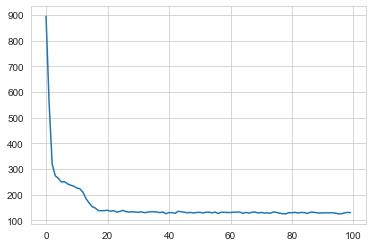

In [103]:
plt.plot(losses)

In [138]:
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
ckpt = torch.load('models/cde_1_test.pth')
score_model.load_state_dict(ckpt)
cde_samples_0 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 1000)
cde_samples_pos = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 1000)
cde_samples_neg = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 1000)

RuntimeError: Error(s) in loading state_dict for ScoreNet:
	size mismatch for net.layers.2.weight: copying a param with shape torch.Size([1, 128]) from checkpoint, the shape in current model is torch.Size([2, 128]).
	size mismatch for net.layers.2.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).

In [170]:
score_model = cde_ScoreNet(marginal_prob_std=marginal_prob_std_fn)
ckpt = torch.load('models/cde_1_test.pth')
score_model.load_state_dict(ckpt)
cde_samples_0 = CDE_test_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 1000)
cde_samples_pos = CDE_test_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 1000)
cde_samples_neg = CDE_test_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 1000)

<ipython-input-17-7120fd0c51ce>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-17-7120fd0c51ce>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

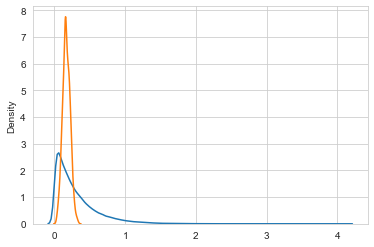

In [173]:
sns.kdeplot(actual_samples_0)
sns.kdeplot(cde_samples_0[:,0])

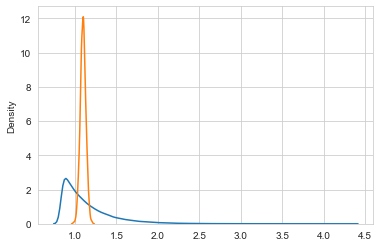

In [171]:
sns.kdeplot(actual_samples_pos)
sns.kdeplot(cde_samples_pos[:,0])

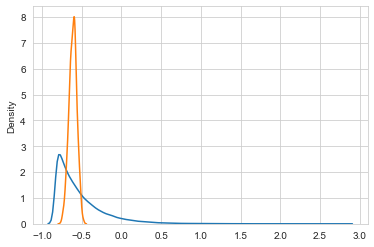

In [172]:
sns.kdeplot(actual_samples_neg)
sns.kdeplot(cde_samples_neg[:,0])

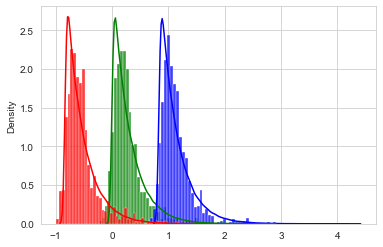

In [22]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(cde_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(cde_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(cde_samples_neg[:,0], stat = 'density', color = 'red')

## Example 2

In [449]:
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/cde_2.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-439-9b7a4042389d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


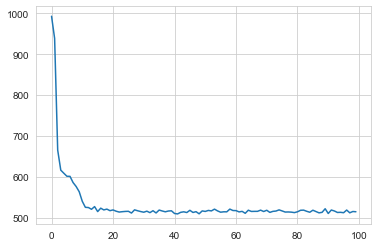

In [450]:
plt.plot(losses)

In [472]:
ckpt = torch.load('models/cde_2.pth', map_location=device)
score_model.load_state_dict(ckpt)
cde_samples_0_2 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 1000)
cde_samples_pos_2 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 1000)
cde_samples_neg_2 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 1000)

<ipython-input-439-9b7a4042389d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-439-9b7a4042389d>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

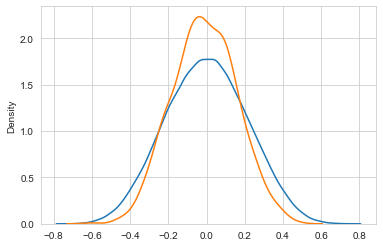

In [477]:
sns.kdeplot(actual_samples_0_2)
sns.kdeplot(cde_samples_0_2[:,0])

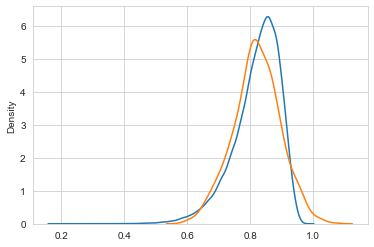

In [478]:
sns.kdeplot(actual_samples_pos_2)
sns.kdeplot(cde_samples_pos_2[:,0])

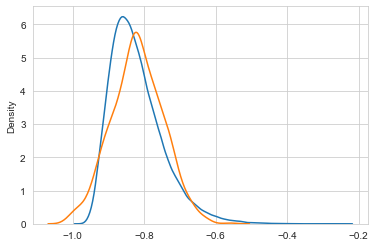

In [479]:
sns.kdeplot(actual_samples_neg_2)
sns.kdeplot(cde_samples_neg_2[:,0])

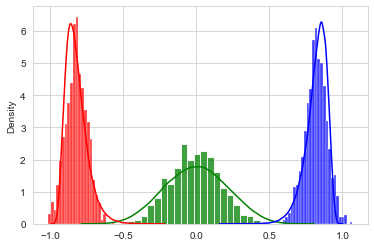

In [480]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(cde_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(cde_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(cde_samples_neg_2[:,0], stat = 'density', color = 'red')

## Example 3

In [456]:
epochs = 100
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_3
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/cde_3.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-439-9b7a4042389d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


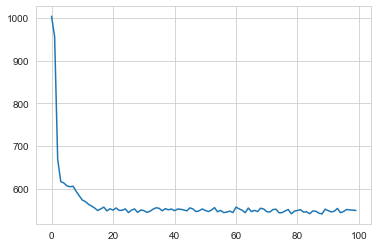

In [457]:
plt.plot(losses)

In [473]:
ckpt = torch.load('models/cde_3.pth', map_location=device)
score_model.load_state_dict(ckpt)

cde_samples_pos_3 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 1000)#,eps=1e-4)
cde_samples_neg_3 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 1000)#,eps=1e-3)

<ipython-input-439-9b7a4042389d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-439-9b7a4042389d>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

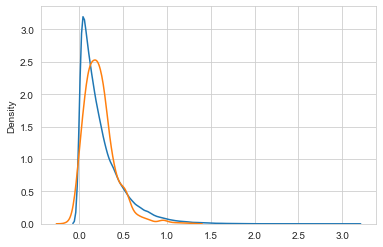

In [474]:
sns.kdeplot(actual_samples_pos_3)
sns.kdeplot(cde_samples_pos_3[:,0])

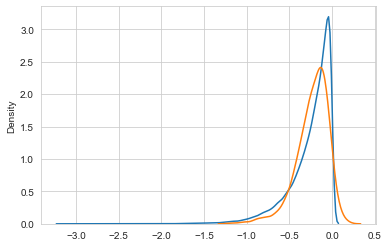

In [475]:
sns.kdeplot(actual_samples_neg_3)
sns.kdeplot(cde_samples_neg_3[:,0])

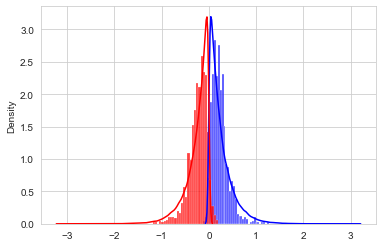

In [476]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(cde_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(cde_samples_neg_3[:,0], stat = 'density', color = 'red')

In [31]:
torch.save(cde_samples_0, 'data/cde_0_1.pt')
torch.save(cde_samples_pos, 'data/cde_pos_1.pt')
torch.save(cde_samples_neg, 'data/cde_neg_1.pt')

torch.save(cde_samples_0_2, 'data/cde_0_2.pt')
torch.save(cde_samples_pos_2, 'data/cde_pos_2.pt')
torch.save(cde_samples_neg_2, 'data/cde_neg_2.pt')

torch.save(cde_samples_pos_3, 'data/cde_pos_3.pt')
torch.save(cde_samples_neg_3, 'data/cde_neg_3.pt')

<hr style="border:2px solid black">

# CDiffE replacement method

I think, in the case of simulating x|y for this synthetic example, the training stays the same. The difference comes in the sampling. For a given y and timestep t, diffuse y to y_t by the standard forward diffusion. Then at each step of the SDE solver, replace the y value with the diffused y_t.

In [26]:
def get_y_t(y_obs, t):
    std = marginal_prob_std_fn(t)
    z = torch.randn_like(y_obs)
    perturbed_y = y_obs + z * std[:, None]
    return perturbed_y

In [27]:
def get_diffused_y(y_obs, timesteps):
    timesteps = torch.flip(timesteps, [0])
    sd = marginal_prob_std_fn(timesteps).reshape(timesteps.shape[0], 1)
    diffused_y = y_obs + torch.randn(timesteps.shape[0], 1) * sd
    return diffused_y

In [28]:
num_steps =  1000
def CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=10000, 
                           num_steps=num_steps,
                           eps=1e-3):

    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 2) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    diffused_y = [i.repeat(batch_size).reshape(batch_size,1) for i in get_diffused_y(y_obs, time_steps)]
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            
            batch_time_step = torch.ones(batch_size) * time_step
            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
            g = diffusion_coeff(batch_time_step)
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x) 

    return mean_x

In [29]:
signal_to_noise_ratio = 0.16
num_steps =  1000

def CDiffE_pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               y_obs,
               batch_size=2048, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               eps=1e-3):

    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 2) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    diffused_y = [i.repeat(batch_size).reshape(batch_size,1) for i in get_diffused_y(y_obs, time_steps)]
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
            
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      
            x_with_t = torch.hstack([x, batch_time_step_])

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)
            
    # The last step does not include any noise
    return x_mean

## Example 1

In [41]:
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
ckpt = torch.load('models/ex_1_test.pth')
score_model.load_state_dict(ckpt)
cdiffe_samples_0 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 1000)

cdiffe_samples_neg = CDiffE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 1000)

cdiffe_samples_pos = CDiffE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 1000)

<ipython-input-17-7120fd0c51ce>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-17-7120fd0c51ce>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

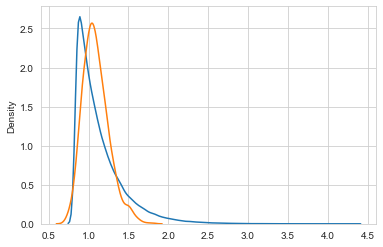

In [42]:
sns.kdeplot(actual_samples_pos)
sns.kdeplot(cdiffe_samples_pos[:,0])

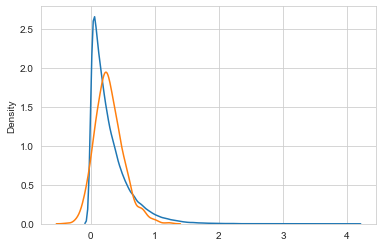

In [43]:
sns.kdeplot(actual_samples_0)
sns.kdeplot(cdiffe_samples_0[:,0])

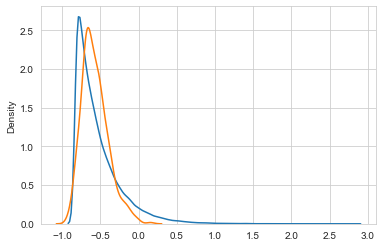

In [44]:
sns.kdeplot(actual_samples_neg)
sns.kdeplot(cdiffe_samples_neg[:,0])

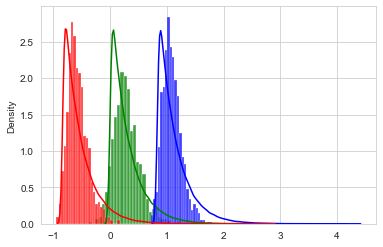

In [45]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(cdiffe_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(cdiffe_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(cdiffe_samples_neg[:,0], stat = 'density', color = 'red')

## Example 2

In [46]:
ckpt = torch.load('models/ex_2_test.pth')
score_model.load_state_dict(ckpt)
cdiffe_samples_0_2 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 1000)

cdiffe_samples_neg_2 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 1000)

cdiffe_samples_pos_2 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 1000)

<ipython-input-17-7120fd0c51ce>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-17-7120fd0c51ce>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

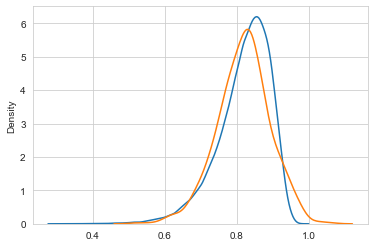

In [47]:
sns.kdeplot(actual_samples_pos_2)
sns.kdeplot(cdiffe_samples_pos_2[:,0])

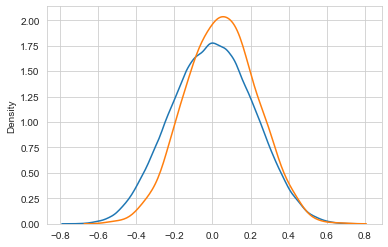

In [48]:
sns.kdeplot(actual_samples_0_2)
sns.kdeplot(cdiffe_samples_0_2[:,0])

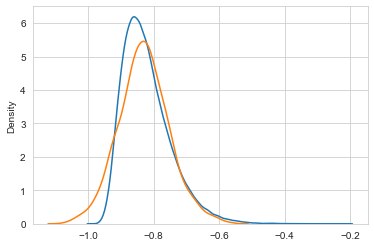

In [49]:
sns.kdeplot(actual_samples_neg_2)
sns.kdeplot(cdiffe_samples_neg_2[:,0])

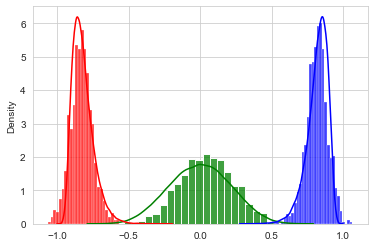

In [50]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(cdiffe_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(cdiffe_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(cdiffe_samples_neg_2[:,0], stat = 'density', color = 'red')

## Example 3

In [51]:
ckpt = torch.load('models/ex_3_test.pth')
score_model.load_state_dict(ckpt)


cdiffe_samples_neg_3 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 1000)

cdiffe_samples_pos_3 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 1000)

<ipython-input-17-7120fd0c51ce>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-17-7120fd0c51ce>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


  0%|          | 0/1000 [00:00<?, ?it/s]

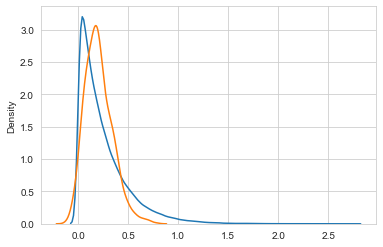

In [52]:
sns.kdeplot(actual_samples_pos_3)
sns.kdeplot(cdiffe_samples_pos_3[:,0])

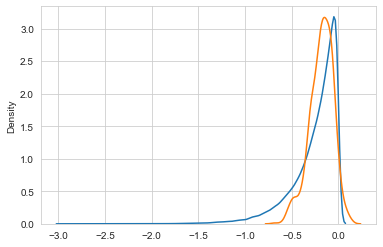

In [53]:
sns.kdeplot(actual_samples_neg_3)
sns.kdeplot(cdiffe_samples_neg_3[:,0])

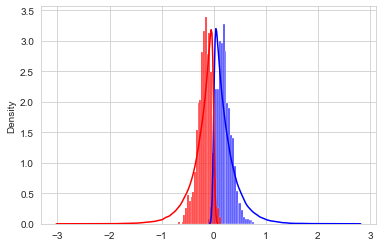

In [54]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(cdiffe_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(cdiffe_samples_neg_3[:,0], stat = 'density', color = 'red')

In [50]:
torch.save(cdiffe_samples_0, 'data/cdiffe_0_1.pt')
torch.save(cdiffe_samples_pos, 'data/cdiffe_pos_1.pt')
torch.save(cdiffe_samples_neg, 'data/cdiffe_neg_1.pt')

torch.save(cdiffe_samples_0_2, 'data/cdiffe_0_2.pt')
torch.save(cdiffe_samples_pos_2, 'data/cdiffe_pos_2.pt')
torch.save(cdiffe_samples_neg_2, 'data/cdiffe_neg_2.pt')

torch.save(cdiffe_samples_pos_3, 'data/cdiffe_pos_3.pt')
torch.save(cdiffe_samples_neg_3, 'data/cdiffe_neg_3.pt')

<hr style="border:2px solid black">

# SMCDiff method

Similar to the replacement method, but need to add SMC step that looks forward one time step to the diffused condition y_{t-1} to reweight the K samples by the probability p(y_{t-1} | x_t, y_t)

In [55]:
def SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std, diffusion_coeff, y_obs, k, 
                                   num_steps=1000, eps=1e-3):
    
    t = torch.ones(k)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    weights = np.ones(k)
    x = torch.randn(k, 2) * marginal_prob_std(t)[:, None]
    diffused_y = [i.repeat(k).reshape(k,1) for i in get_diffused_y(y_obs, time_steps)]
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):            
            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
            
            if (idx - 1) >= 0:
                y_update_mean, sd = get_next_x(x, k, score_model, diffusion_coeff, time_step, step_size)
                y_update_mean = y_update_mean[:,1]
                y_update_actual = diffused_y[idx-1].flatten()

                log_w = log_normal_density(y_update_actual, y_update_mean, sd.flatten())
                log_w -= torch.logsumexp(log_w, 0)
                weights = torch.exp(log_w).cpu().detach().numpy()
                weights /= sum(weights)
                
                resample_index = systematic(weights, k)
                x = x[resample_index]
                weights = np.ones_like(weights)
            
            mu, sd = get_next_x(x, k, score_model, diffusion_coeff, time_step, step_size)
            x = mu + sd * torch.randn_like(x) 
            
    return mu

In [56]:
def SMCDiff_pc_sampler(score_model, marginal_prob_std, diffusion_coeff, y_obs, k, 
                                   snr=signal_to_noise_ratio, num_steps=1000, eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    y_obs: A tensor of the conditional y information
    k: The number of particles used in particle filtering
    batch_size: The number of samples to generate by calling this function once.
    num_steps: The number of sampling steps. Equivalent to the number of discretized time steps.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(k)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    weights = np.ones(k)/k
    xs = []
    init_x = torch.randn(k, 2) * marginal_prob_std(t)[:, None]
    xs.append(init_x)
    diffused_y = [i.repeat(k).reshape(k,1) for i in get_diffused_y(y_obs, time_steps)]
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            batch_time_step = torch.ones(k) * time_step
            y_obs_t = diffused_y[idx]
            x = xs[-1]
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
                        
            if (idx - 1) >= 0:
                y_update_mean, sd = get_next_x(x, k, score_model, diffusion_coeff, time_step, step_size)
                y_update_mean = y_update_mean[:,1]
                y_update_actual = diffused_y[idx-1].flatten()


                log_w = log_normal_density(y_update_actual, y_update_mean, sd.flatten())
                log_w -= torch.logsumexp(log_w, 0)

                weights = torch.exp(log_w).cpu().detach().numpy()
                weights /= sum(weights) 
                
                resample_index = systematic(weights, k)
                x = x[resample_index]
                weights = np.ones_like(weights)
                
            #corrector step (Langevin MCMC)
            batch_time_step = torch.reshape(torch.ones(k) * time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step])
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
            
            mu, sd = get_next_x(x, k, score_model, diffusion_coeff, time_step, step_size)
            x_t_1 = mu + sd * torch.randn_like(x) 
            xs.append(x_t_1)

    return xs[-1]

In [57]:
def get_log_w(y, mean, sd):
    norm = np.linalg.norm(y-mean, axis=1)
    return -torch.tensor(norm)

In [58]:
def log_normal_density(sample, mean, sd):
    return Normal(loc=mean, scale=sd).log_prob(sample)

In [59]:
def get_next_x(x, batch_size, score_model, diffusion_coeff, time_step, step_size):
    #returns the predicted (x_{t-1}, y_{t-1}) based on the current diffused (x_t, y_t)
    batch_time_step = torch.ones(batch_size) * time_step
    g = diffusion_coeff(batch_time_step)
    batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
    x_with_t = torch.hstack([x, batch_time_step_])
    mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
    sd = torch.sqrt(step_size) * g[:, None]
    return mean_x, sd

In [60]:
def inverse_cdf(su, W):
    """Inverse CDF algorithm for a finite distribution.

        Parameters
        ----------
        su: (M,) ndarray
            M sorted uniform variates (i.e. M ordered points in [0,1]).
        W: (N,) ndarray
            a vector of N normalized weights (>=0 and sum to one)

        Returns
        -------
        A: (M,) ndarray
            a vector of M indices in range 0, ..., N-1
    """
    j = 0
    s = W[0]
    M = su.shape[0]
    A = np.empty(M, dtype=np.int64)
    for n in range(M):
        while su[n] > s:
            if j <W.shape[0]-1:
                j += 1
            s += W[j]
        A[n] = j
    return A

In [61]:
def multinomial_resample(weights):
    """ This is the naive form of roulette sampling where we compute the
    cumulative sum of the weights and then use binary search to select the
    resampled point based on a uniformly distributed random number. Run time
    is O(n log n). You do not want to use this algorithm in practice; for some
    reason it is popular in blogs and online courses so I included it for
    reference.

   Parameters
   ----------

    weights : list-like of float
        list of weights as floats

    Returns
    -------

    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors: ensures sum is exactly one
    return np.searchsorted(cumulative_sum, np.random.rand(len(weights)))

In [62]:
def residual(W):
    """Residual resampling.
    """
    N = W.shape[0]
    M = N
    A = np.empty(M, dtype=np.int64)
    MW = M * W
    intpart = np.floor(MW).astype(np.int64)
    sip = np.sum(intpart)
    res = MW - intpart
    sres = M - sip
    A[:sip] = np.arange(N).repeat(intpart)
    # each particle n is repeated intpart[n] times
    if sres > 0:
        A[sip:] = multinomial(res / sres, M=sres)
    return A

In [63]:
def systematic(W, M):
    """Systematic resampling.
    """
    su = (np.random.rand(1) + np.arange(M)) / M
    return inverse_cdf(su, W)

In [64]:
def multinomial(W, M):
    """Multinomial resampling.

    Popular resampling scheme, which amounts to sample N independently from
    the multinomial distribution that generates n with probability W^n. 

    This resampling scheme is *not* recommended for various reasons; basically
    schemes like stratified / systematic / SSP tends to introduce less noise,
    and may be faster too (in particular systematic). 
    """
    return inverse_cdf(uniform_spacings(M), W)

In [65]:
def uniform_spacings(N):
    """Generate ordered uniform variates in O(N) time.

    Parameters
    ----------
    N: int (>0)
        the expected number of uniform variates

    Returns
    -------
    (N,) float ndarray
        the N ordered variates (ascending order)

    Note
    ----
    This is equivalent to::

        from numpy import random
        u = sort(random.rand(N))

    but the line above has complexity O(N*log(N)), whereas the algorithm
    used here has complexity O(N).

    """
    z = np.cumsum(-np.log(np.random.rand(N + 1)))
    return z[:-1] / z[-1]


In [66]:
def get_diffused_y(y_obs, timesteps):
    timesteps = torch.flip(timesteps, [0])
    sd = marginal_prob_std_fn(timesteps).reshape(timesteps.shape[0], 1)
    diffused_y = y_obs + torch.randn(timesteps.shape[0], 1) * sd
    return diffused_y

## Example 1

In [67]:
ckpt = torch.load('models/ex_1_test.pth')
score_model.load_state_dict(ckpt)

smcdiff_samples_0 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), k = 1000)

smcdiff_samples_pos = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), k = 1000)

smcdiff_samples_neg = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), k = 1000)

<ipython-input-17-7120fd0c51ce>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-17-7120fd0c51ce>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

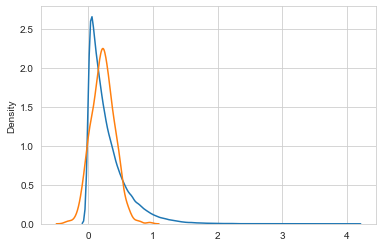

In [68]:
sns.kdeplot(actual_samples_0)
sns.kdeplot(smcdiff_samples_0[:,0])

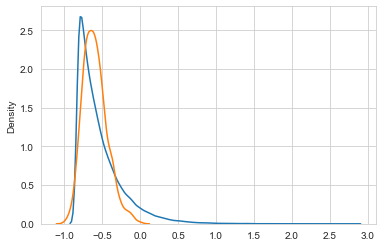

In [69]:
sns.kdeplot(actual_samples_neg)
sns.kdeplot(smcdiff_samples_neg[:,0])

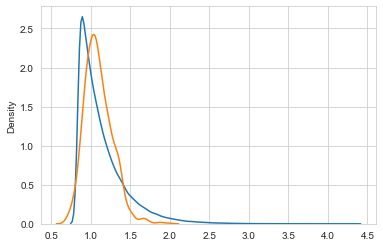

In [70]:
sns.kdeplot(actual_samples_pos)
sns.kdeplot(smcdiff_samples_pos[:,0])

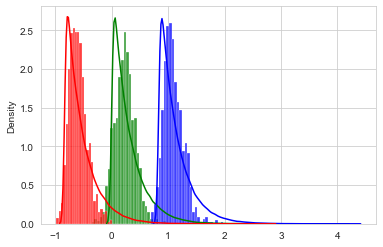

In [71]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(smcdiff_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(smcdiff_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(smcdiff_samples_neg[:,0], stat = 'density', color = 'red')

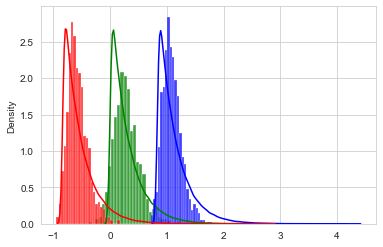

In [72]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(cdiffe_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(cdiffe_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(cdiffe_samples_neg[:,0], stat = 'density', color = 'red')

## Example 2

In [74]:
ckpt = torch.load('models/ex_2_test.pth')
score_model.load_state_dict(ckpt)
smcdiff_samples_0_2 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), k = 1000)

smcdiff_samples_pos_2 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), k = 1000)

smcdiff_samples_neg_2 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), k = 1000)

<ipython-input-17-7120fd0c51ce>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-17-7120fd0c51ce>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

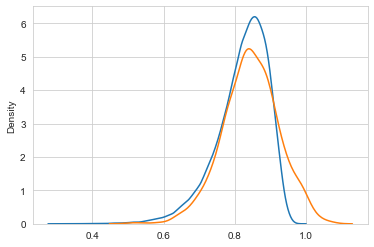

In [76]:
sns.kdeplot(actual_samples_pos_2)
sns.kdeplot(smcdiff_samples_pos_2[:,0])

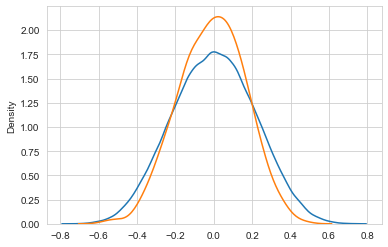

In [77]:
sns.kdeplot(actual_samples_0_2)
sns.kdeplot(smcdiff_samples_0_2[:,0])

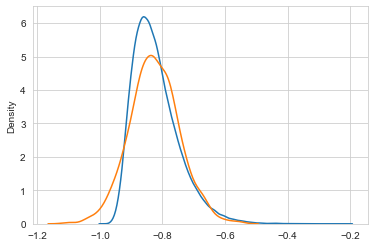

In [78]:
sns.kdeplot(actual_samples_neg_2)
sns.kdeplot(smcdiff_samples_neg_2[:,0])

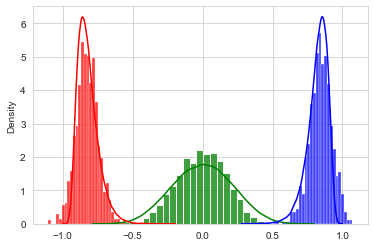

In [79]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(smcdiff_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(smcdiff_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(smcdiff_samples_neg_2[:,0], stat = 'density', color = 'red')

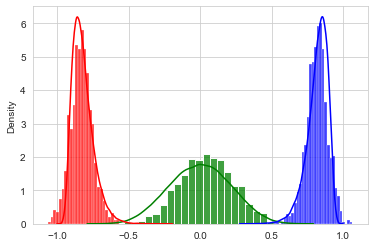

In [80]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(cdiffe_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(cdiffe_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(cdiffe_samples_neg_2[:,0], stat = 'density', color = 'red')

## Example 3

In [82]:
ckpt = torch.load('models/ex_3_test.pth')
score_model.load_state_dict(ckpt)
smcdiff_samples_pos_3 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), k = 1000)

smcdiff_samples_neg_3 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), k = 1000)

<ipython-input-17-7120fd0c51ce>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-17-7120fd0c51ce>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)


  0%|          | 0/1000 [00:00<?, ?it/s]

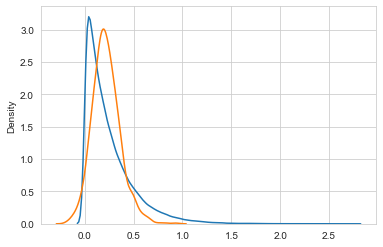

In [83]:
sns.kdeplot(actual_samples_pos_3)
sns.kdeplot(smcdiff_samples_pos_3[:,0])

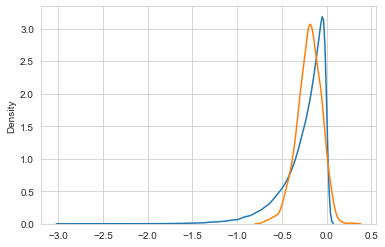

In [84]:
sns.kdeplot(actual_samples_neg_3)
sns.kdeplot(smcdiff_samples_neg_3[:,0])

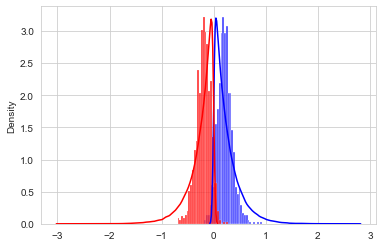

In [85]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(smcdiff_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(smcdiff_samples_neg_3[:,0], stat = 'density', color = 'red')

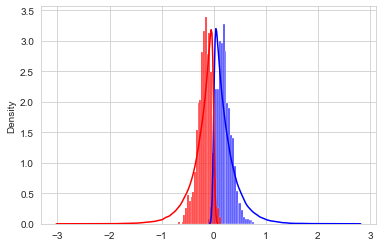

In [86]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(cdiffe_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(cdiffe_samples_neg_3[:,0], stat = 'density', color = 'red')

In [121]:
torch.save(smcdiff_samples_0, 'data/smcdiff_0_1.pt')
torch.save(smcdiff_samples_pos, 'data/smcdiff_pos_1.pt')
torch.save(smcdiff_samples_neg, 'data/smcdiff_neg_1.pt')

torch.save(smcdiff_samples_0_2, 'data/smcdiff_0_2.pt')
torch.save(smcdiff_samples_pos_2, 'data/smcdiff_pos_2.pt')
torch.save(smcdiff_samples_neg_2, 'data/smcdiff_neg_2.pt')

torch.save(smcdiff_samples_pos_3, 'data/smcdiff_pos_3.pt')
torch.save(smcdiff_samples_neg_3, 'data/smcdiff_neg_3.pt')

<hr style="border:2px solid black">

# Comparison

In [75]:
cde_samples_0 = torch.load('data/cde_0_1.pt')
cde_samples_pos = torch.load('data/cde_pos_1.pt')
cde_samples_neg = torch.load('data/cde_neg_1.pt')
cde_samples_0_2 = torch.load('data/cde_0_2.pt')
cde_samples_pos_2 = torch.load('data/cde_pos_2.pt')
cde_samples_neg_2 = torch.load('data/cde_neg_2.pt')
cde_samples_pos_3 = torch.load('data/cde_pos_3.pt')
cde_samples_neg_3 = torch.load('data/cde_neg_3.pt')

In [ ]:
cdiffe_samples_0 = torch.load('data/cdiffe_0_1.pt')
cdiffe_samples_pos = torch.load('data/cdiffe_pos_1.pt')
cdiffe_samples_neg = torch.load('data/cdiffe_neg_1.pt')
cdiffe_samples_0_2 = torch.load('data/cdiffe_0_2.pt')
cdiffe_samples_pos_2 = torch.load('data/cdiffe_pos_2.pt')
cdiffe_samples_neg_2 = torch.load('data/cdiffe_neg_2.pt')
cdiffe_samples_pos_3 = torch.load('data/cdiffe_pos_3.pt')
cdiffe_samples_neg_3 = torch.load('data/cdiffe_neg_3.pt')

In [ ]:
smcdiff_samples_0 = torch.load('data/smcdiff_0_1.pt')
smcdiff_samples_pos = torch.load('data/smcdiff_pos_1.pt')
smcdiff_samples_neg = torch.load('data/smcdiff_neg_1.pt')
smcdiff_samples_0_2 = torch.load('data/smcdiff_0_2.pt')
smcdiff_samples_pos_2 = torch.load('data/smcdiff_pos_2.pt')
smcdiff_samples_neg_2 = torch.load('data/smcdiff_neg_2.pt')
smcdiff_samples_pos_3 = torch.load('data/smcdiff_pos_3.pt')
smcdiff_samples_neg_3 = torch.load('data/smcdiff_neg_3.pt')

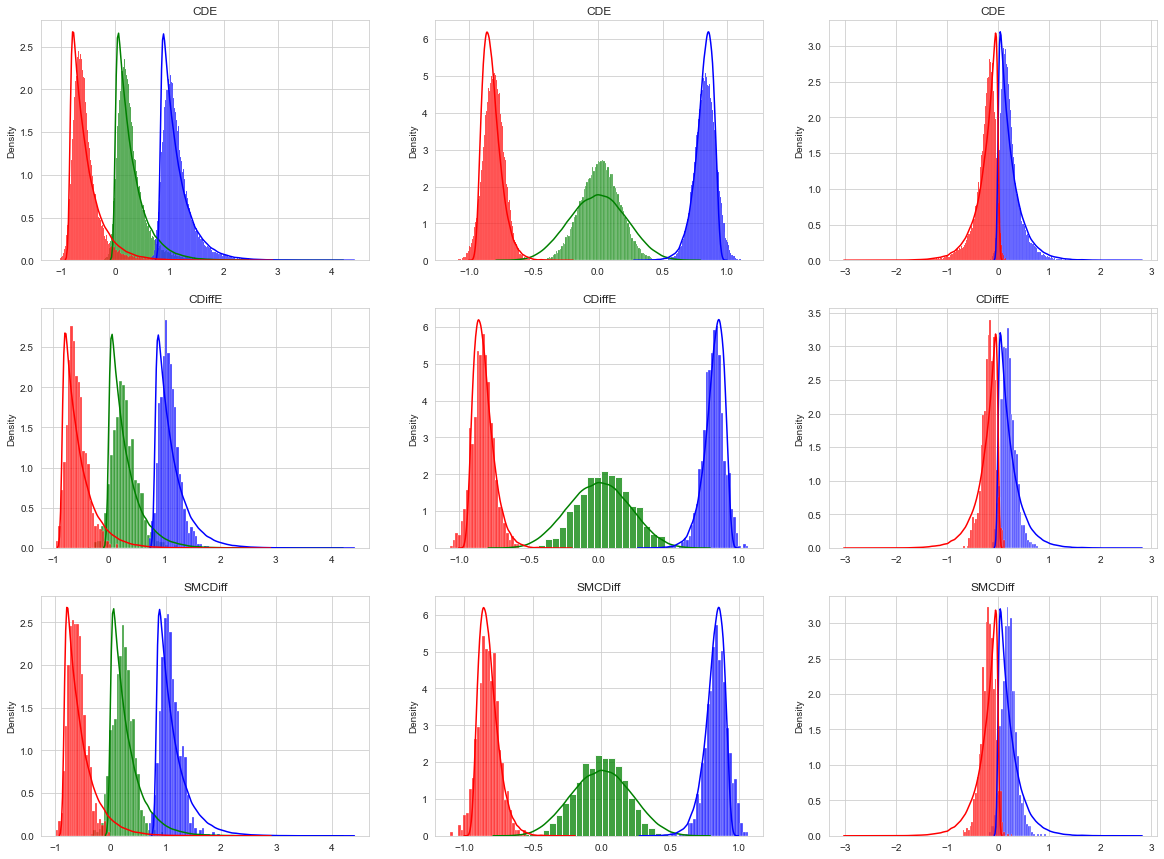

In [87]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 15))

def plot_row(s1,s2,s3,s4,s5,s6,s7,s8,row,title):
    sns.kdeplot(actual_samples_0, color = 'green', ax = axs[row,0])
    sns.histplot(s1[:,0], stat = 'density', color = 'green', ax = axs[row,0])
    sns.kdeplot(actual_samples_pos, color = 'blue', ax = axs[row,0])
    sns.histplot(s2[:,0], stat = 'density', color = 'blue', ax = axs[row,0])
    sns.kdeplot(actual_samples_neg, color = 'red', ax = axs[row,0])
    sns.histplot(s3[:,0], stat = 'density', color = 'red', ax = axs[row,0])

    sns.kdeplot(actual_samples_0_2, color = 'green', ax = axs[row,1])
    sns.histplot(s4[:,0], stat = 'density', color = 'green', ax = axs[row,1])
    sns.kdeplot(actual_samples_pos_2, color = 'blue', ax = axs[row,1])
    sns.histplot(s5[:,0], stat = 'density', color = 'blue', ax = axs[row,1])
    sns.kdeplot(actual_samples_neg_2, color = 'red', ax = axs[row,1])
    sns.histplot(s6[:,0], stat = 'density', color = 'red', ax = axs[row,1])

    sns.kdeplot(actual_samples_pos_3, color = 'blue', ax = axs[row,2])
    sns.histplot(s7[:,0], stat = 'density', color = 'blue', ax = axs[row,2])
    sns.kdeplot(actual_samples_neg_3, color = 'red', ax = axs[row,2])
    sns.histplot(s8[:,0], stat = 'density', color = 'red', ax = axs[row,2])

    axs[row,0].set_title(title)
    axs[row,1].set_title(title)
    axs[row,2].set_title(title)
    
plot_row(cde_samples_0, cde_samples_pos, cde_samples_neg, 
         cde_samples_0_2, cde_samples_pos_2, cde_samples_neg_2,
         cde_samples_pos_3, cde_samples_neg_3, 0, 'CDE')

plot_row(cdiffe_samples_0, cdiffe_samples_pos, cdiffe_samples_neg, 
         cdiffe_samples_0_2, cdiffe_samples_pos_2, cdiffe_samples_neg_2,
         cdiffe_samples_pos_3, cdiffe_samples_neg_3, 1, 'CDiffE')

plot_row(smcdiff_samples_0, smcdiff_samples_pos, smcdiff_samples_neg, 
         smcdiff_samples_0_2, smcdiff_samples_pos_2, smcdiff_samples_neg_2,
         smcdiff_samples_pos_3, smcdiff_samples_neg_3, 2, 'SMCDiff')

In [88]:
print(np.mean(actual_samples_0))
print(torch.mean(cde_samples_0))
print(torch.mean(cdiffe_samples_0))
print(torch.mean(smcdiff_samples_0))

0.3005491984756099
tensor(0.1464)
tensor(0.1474)
tensor(0.1168)


In [89]:
print(np.mean(actual_samples_pos))
print(torch.mean(cde_samples_pos))
print(torch.mean(cdiffe_samples_pos))
print(torch.mean(smcdiff_samples_pos))

1.1345320199942488
tensor(1.1693)
tensor(1.1524)
tensor(1.1403)


In [90]:
print(np.mean(actual_samples_neg))
print(torch.mean(cde_samples_neg))
print(torch.mean(cdiffe_samples_neg))
print(torch.mean(smcdiff_samples_neg))

-0.535091814637213
tensor(-0.8749)
tensor(-0.9070)
tensor(-0.8984)


In [91]:
print(np.mean(actual_samples_0_2))
print(torch.mean(cde_samples_0_2))
print(torch.mean(cdiffe_samples_0_2))
print(torch.mean(smcdiff_samples_0_2))

0.0006479151657738687
tensor(0.0079)
tensor(0.0001)
tensor(-0.0182)


In [92]:
print(np.mean(actual_samples_pos_2))
print(torch.mean(cde_samples_pos_2))
print(torch.mean(cdiffe_samples_pos_2))
print(torch.mean(smcdiff_samples_pos_2))

0.8210357442218019
tensor(1.0154)
tensor(1.0081)
tensor(1.0426)


In [93]:
print(np.mean(actual_samples_neg_2))
print(torch.mean(cde_samples_neg_2))
print(torch.mean(cdiffe_samples_neg_2))
print(torch.mean(smcdiff_samples_neg_2))

-0.8206993517207999
tensor(-1.0043)
tensor(-0.9916)
tensor(-1.0063)


In [94]:
print(np.mean(actual_samples_pos_3))
print(torch.mean(cde_samples_pos_3))
print(torch.mean(cdiffe_samples_pos_3))
print(torch.mean(smcdiff_samples_pos_3))

0.24985681522207376
tensor(0.7192)
tensor(0.6828)
tensor(0.7243)


In [95]:
print(np.mean(actual_samples_neg_3))
print(torch.mean(cde_samples_neg_3))
print(torch.mean(cdiffe_samples_neg_3))
print(torch.mean(smcdiff_samples_neg_3))

-0.25006904248021977
tensor(-0.7277)
tensor(-0.6911)
tensor(-0.7217)
